In [1]:
import jcopdl, luwiji
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset dan DataLoader

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("../../data CNN/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("../../data CNN/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [3]:
features, labels = next(iter(trainloader))
features.shape

torch.Size([128, 3, 64, 64])

In [4]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [5]:
# nn.Conv2d(in_channels= 3, out_channels= 8, kernel_size= 3, stride=1, padding=1)
# nn.ReLU()
# nn.MaxPool2d(kernel_size=2, stride=2)

In [6]:
from jcopdl.layers import conv_block, linear_block

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # c_out itu filter
        self.conv = nn.Sequential(
          # awalnya gambarnya 64 x 64
          # 3 itu channel nya, karna RGB
            # # 1st conv block  
            # nn.Conv2d(in_channels= 3, out_channels= 8, kernel_size= 3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            # # 2nd conv block  
            # nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            # # 3rd conv block  
            # nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            # # 4th conv block  
            # nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
          
            conv_block(c_in= 3, c_out= 8, pool_type= 'max'), # 32 x 32
            conv_block(c_in= 8, c_out= 16, pool_type= 'max'), # 16 x 16
            conv_block(c_in= 16, c_out= 32, pool_type= 'max'), # 8 x 8
            conv_block(c_in= 32, c_out= 64, pool_type= 'max'), # 4 x 4
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
          # nah abis kena pooling, trus 64 nya itu dia dari c_out conv terakhir
          linear_block(64*4*4, 256, activation='relu', dropout=0.1),
          linear_block(256, 2, activation="lsoftmax")
        )
        
        
    def forward(self, x):
      x = self.conv(x)
      x = self.fc(x)
      return x


In [7]:
config = set_config({
    "crop_size": crop_size,
    "batch_size": bs,
})

# Training Preparation -> MCOC

In [8]:
model = CNN().to(device)
criterion = nn.NLLLoss() # karena kita pake lsoftmax, jadi ga pake nn.CrossEntropyLoss() lagi
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Trainning

## training loop function 

In [9]:
from tqdm.auto import tqdm


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

## Traning

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6902 | Test_cost  = 0.6824 | Train_score = 0.5260 | Test_score = 0.5000 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6618 | Test_cost  = 0.5961 | Train_score = 0.6160 | Test_score = 0.7350 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5416 | Test_cost  = 0.4680 | Train_score = 0.7560 | Test_score = 0.7625 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4643 | Test_cost  = 0.4249 | Train_score = 0.7880 | Test_score = 0.7950 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4773 | Test_cost  = 0.4663 | Train_score = 0.7690 | Test_score = 0.7575 |
==> EarlyStop patience =  1 | Best test_score: 0.7950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4393 | Test_cost  = 0.4630 | Train_score = 0.7890 | Test_score = 0.7600 |
==> EarlyStop patience =  2 | Best test_score: 0.7950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4332 | Test_cost  = 0.4193 | Train_score = 0.8030 | Test_score = 0.8050 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4224 | Test_cost  = 0.3769 | Train_score = 0.8080 | Test_score = 0.8250 |


Train:   0%|          | 0/8 [02:20<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4073 | Test_cost  = 0.3739 | Train_score = 0.8100 | Test_score = 0.8350 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3977 | Test_cost  = 0.3612 | Train_score = 0.8180 | Test_score = 0.8450 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3971 | Test_cost  = 0.3589 | Train_score = 0.8240 | Test_score = 0.8400 |
==> EarlyStop patience =  1 | Best test_score: 0.8450


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3852 | Test_cost  = 0.3565 | Train_score = 0.8250 | Test_score = 0.8425 |
==> EarlyStop patience =  2 | Best test_score: 0.8450


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3924 | Test_cost  = 0.3681 | Train_score = 0.8110 | Test_score = 0.8500 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3841 | Test_cost  = 0.3482 | Train_score = 0.8340 | Test_score = 0.8550 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3691 | Test_cost  = 0.3501 | Train_score = 0.8420 | Test_score = 0.8500 |
==> EarlyStop patience =  1 | Best test_score: 0.8550


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3657 | Test_cost  = 0.3855 | Train_score = 0.8350 | Test_score = 0.8275 |
==> EarlyStop patience =  2 | Best test_score: 0.8550


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3642 | Test_cost  = 0.3797 | Train_score = 0.8380 | Test_score = 0.8275 |
==> EarlyStop patience =  3 | Best test_score: 0.8550


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3680 | Test_cost  = 0.4018 | Train_score = 0.8320 | Test_score = 0.7925 |
==> EarlyStop patience =  4 | Best test_score: 0.8550


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3635 | Test_cost  = 0.3407 | Train_score = 0.8410 | Test_score = 0.8525 |
==> EarlyStop patience =  5 | Best test_score: 0.8550
==> Execute Early Stopping at epoch: 19 | Best test_score: 0.8550
==> Best model is saved at model


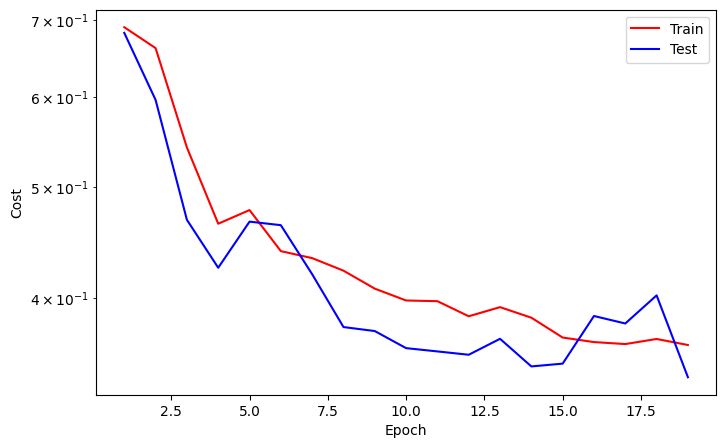

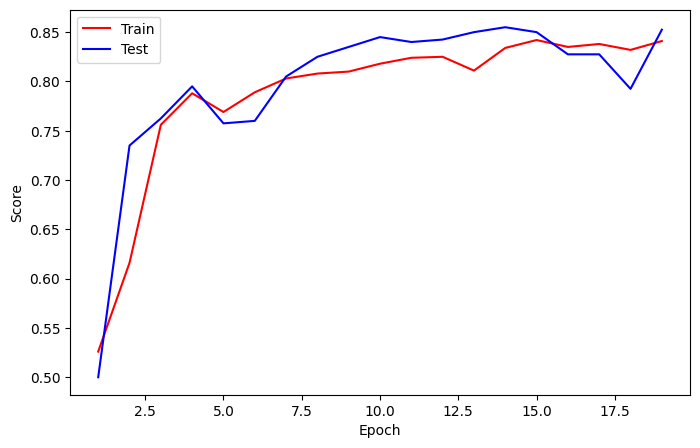

In [10]:
# Training
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Perbedaan2 <br>

<img src = "https://cdn.discordapp.com/attachments/969207152679993414/1063465713110618112/image.png">

# Predict

In [16]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [17]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
    # prob = output.softmax(1)
preds

tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0])

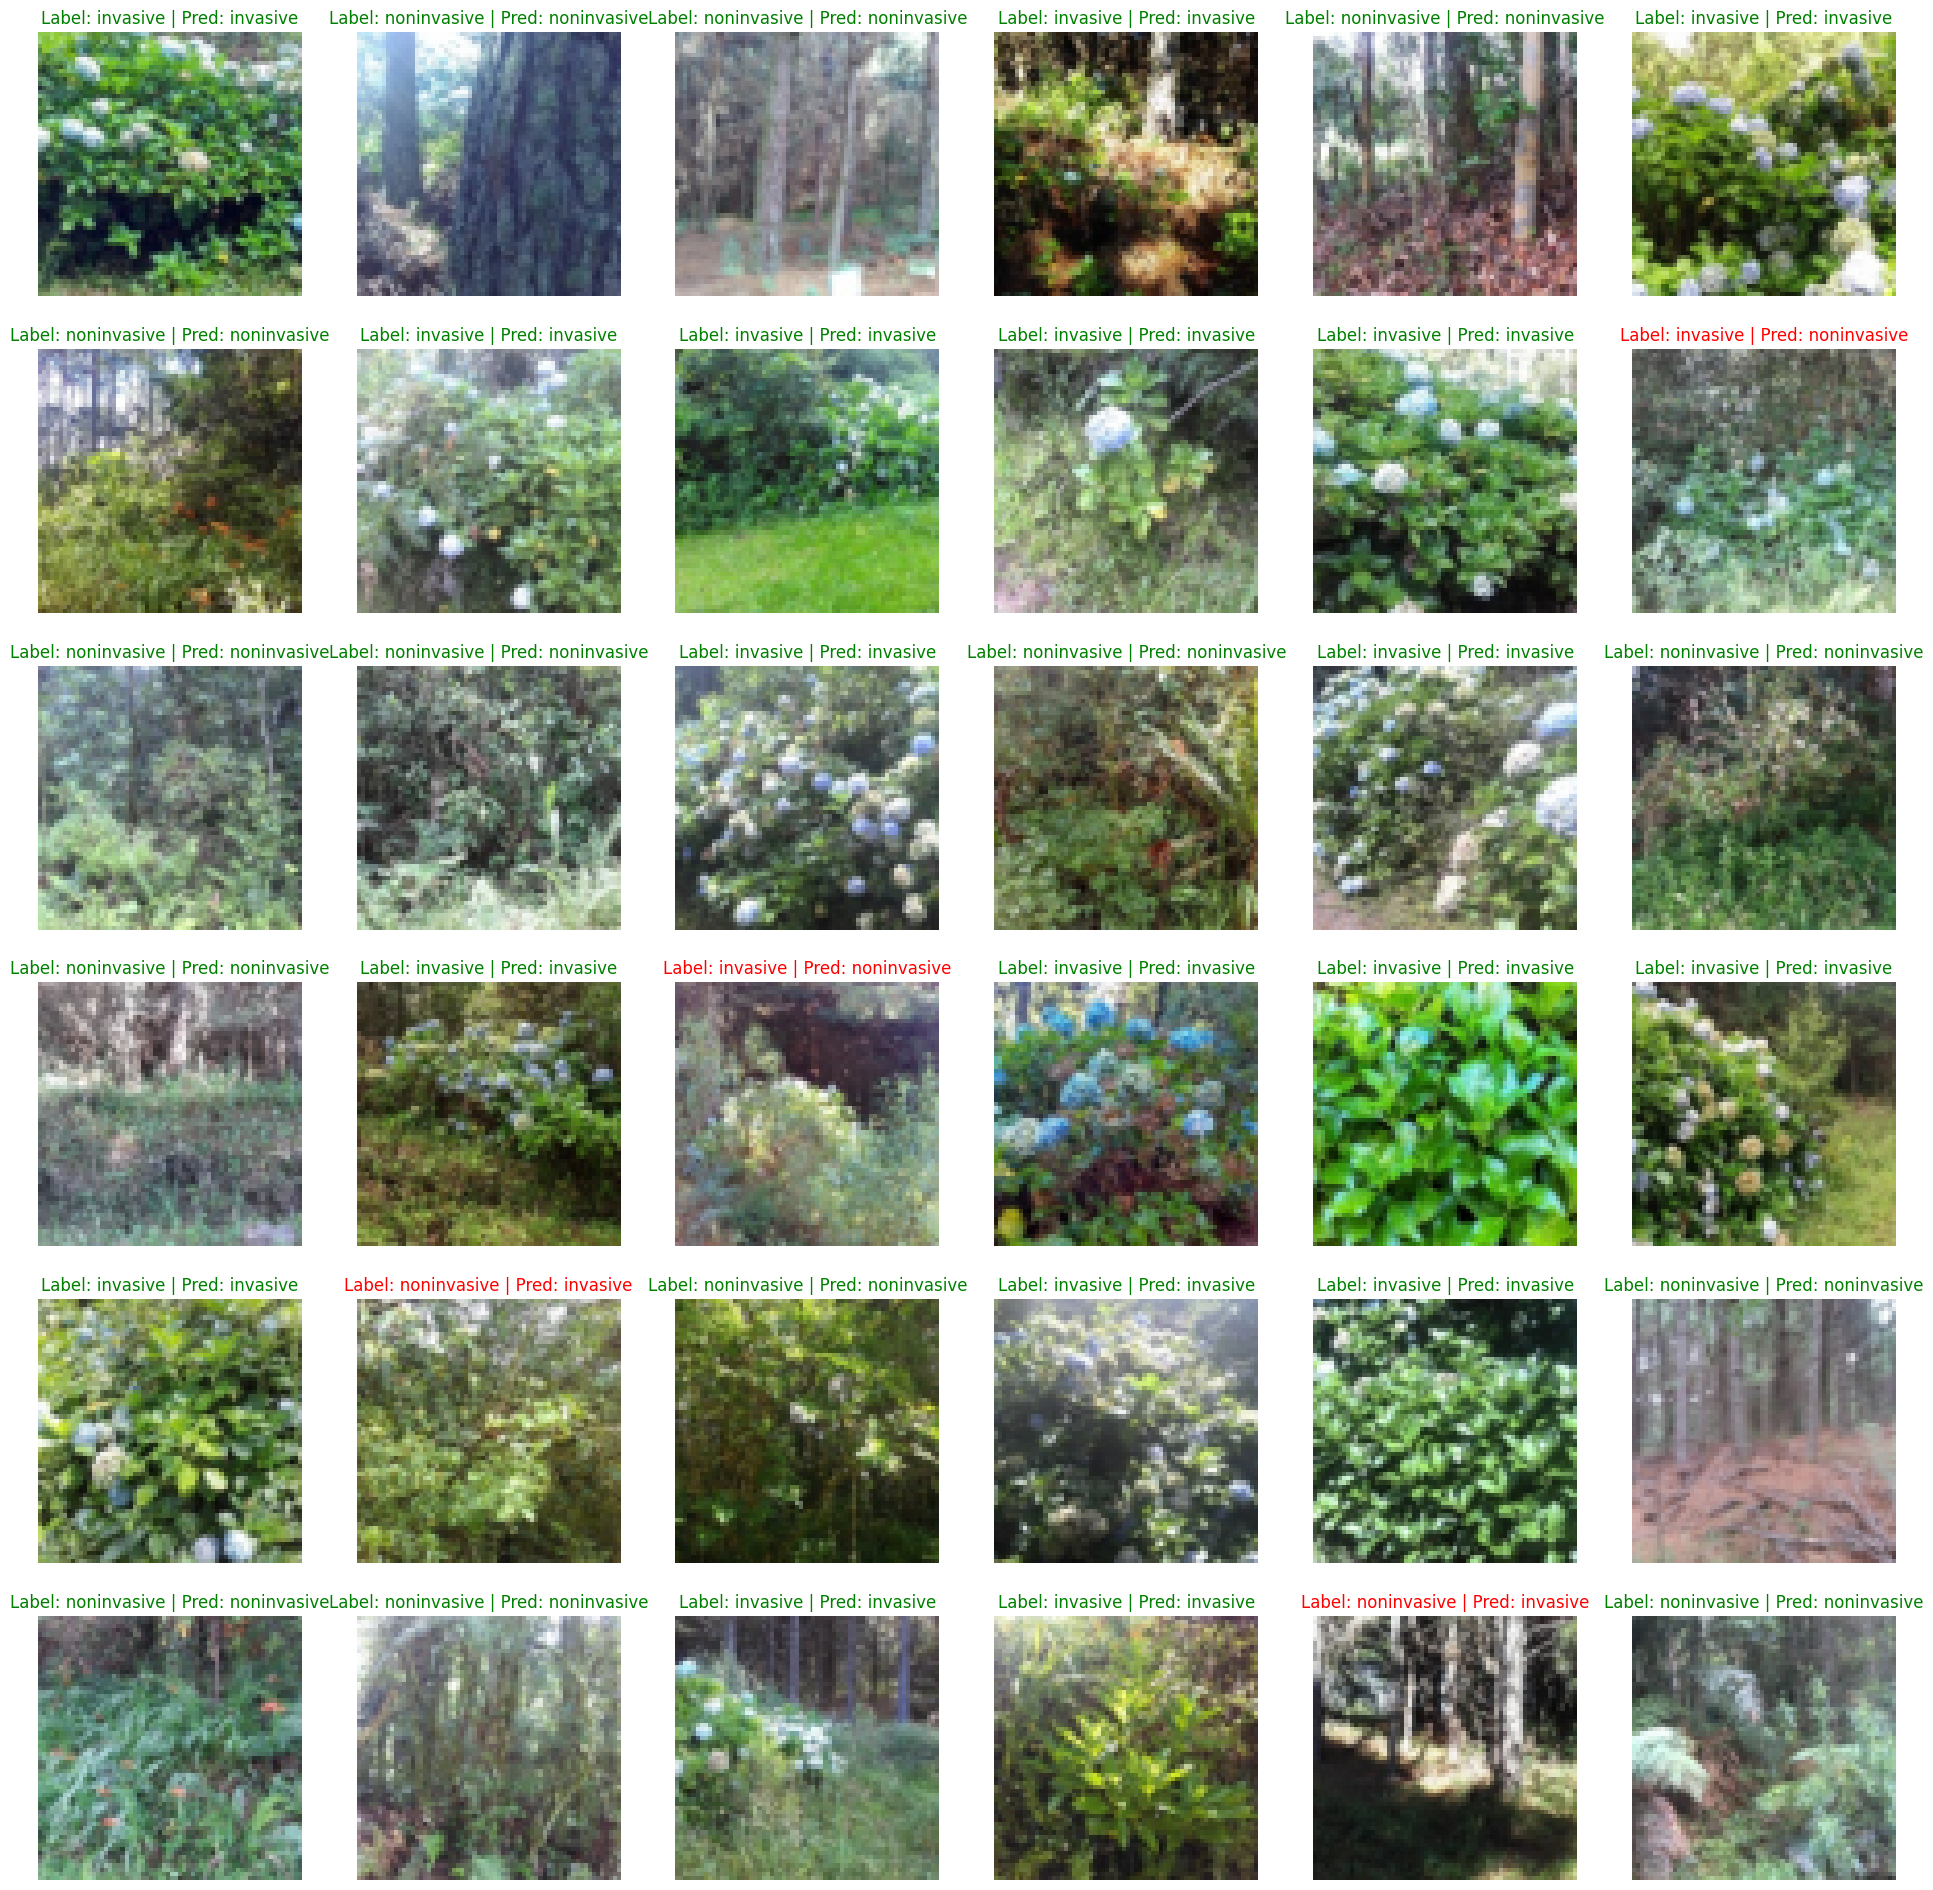

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, ax.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color": "red"} if label != pred else {"color": "green"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font)
    ax.axis("off")